In [1]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from PIL import Image
import torch
from peft import PeftModel


import os
os.environ['HF_HOME'] = '/mnt/efs/hf_cache'

base_model_id = "Qwen/Qwen2.5-VL-7B-Instruct"
processor = Qwen2VLProcessor.from_pretrained(
    base_model_id, 
    trust_remote_code=True,
    use_fast=False 
)

model = Qwen2VLForConditionalGeneration.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto",    
    force_download=True  # <-- Forces a fresh download

)

# adapter_path = "fine-tuned-qwen2/lora_epoch_15"
# model = PeftModel.from_pretrained(model, adapter_path)

model.eval()

OSError: Qwen/Qwen2.5-VL-7B-Instruct does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct/tree/main'for available files.

In [2]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

ModuleNotFoundError: No module named 'qwen_vl_utils'

In [2]:
!pwd

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
/mnt/efs/garvit_data/LLM_Finetune


In [2]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
print(f"Reserved : {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

Allocated: 15818.06 MB
Reserved : 17898.00 MB


In [3]:
# !pip install opencv-python

In [4]:
import os
import cv2
import json
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# def load_cigroupdata():
#     """Load dataset of images and JSON annotations"""
#     dirp = 'CIGroups'
#     outsp = {}
#     samples = 0
    
#     for root, _, files in os.walk(dirp):
#         for file in files:
#             if file.endswith('.json'):
#                 continue
#             key = os.path.basename(root)
#             fullpath = os.path.join(root, file)
#             fullpath_v2 = os.path.join(root, file + '_geo.json')
    
#             if os.path.isfile(fullpath) and os.path.isfile(fullpath_v2):
#                 if key not in outsp:
#                     outsp[key] = []
#                 outsp[key].append((fullpath, fullpath_v2))
#                 samples += 1
    
#     datalist = [item for v in outsp.values() for item in v if len(v) >= 2]
    
#     return datalist

In [6]:
def load_cigroupdata():
    """Load dataset of images and JSON annotations"""
    dirp = 'CIGroups'
    outsp = {}
    samples = 0

    for root, _, files in os.walk(dirp):
        for file in files:
            if file.endswith('.json'):
                continue
            key = os.path.basename(root)
            fullpath = os.path.join(root, file)
            fullpath_v2 = os.path.join(root, file + '_geo.json')

            if os.path.isfile(fullpath) and os.path.isfile(fullpath_v2):
                if key not in outsp:
                    outsp[key] = []
                outsp[key].append((fullpath, fullpath_v2))
                samples += 1

    datalist = [v for v in outsp.values() if len(v) >= 2]
    return datalist

In [7]:
print("size of the dataset is: ", len(load_cigroupdata()))

size of the dataset is:  161


In [8]:
sample = load_cigroupdata()

In [9]:
print(sample[0])

[('CIGroups/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png', 'CIGroups/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png_geo.json'), ('CIGroups/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-410_oYuikMhJGdZGbDV72oCx_2.png', 'CIGroups/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-410_oYuikMhJGdZGbDV72oCx_2.png_geo.json'), ('CIGroups/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-412_ZqV4nmPjfO5qao1Oqy99_2.png', 'CIGroups/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-435_4GMX6y46mOdxQsLwD3Cr_2.png/KX-P2D4-295_puEA6K49SoBJaN62Os5l_2__KX-P2D4-412_ZqV4nmPjfO5qao1Oqy99_2.png_geo.js

In [10]:
def get_image_and_jsongt(sample):
    """Extract OCR words and their bounding boxes from JSON"""
    img_path, json_path = sample
    
    with open(json_path, encoding="utf8") as f:
        json_data = json.load(f)
    
    word_boxes = []
    for clas in json_data['parse']['class']:
        items = json_data['parse']['class'][clas]
        for item in items:
            for wrd_id in item:
                word = json_data['words'][wrd_id]['text']
                bbox = json_data['words'][wrd_id]['boundingBox'][0] + json_data['words'][wrd_id]['boundingBox'][2]
                rlabel = json_data['words'][wrd_id].get('row_label', [0])[0]
                word_boxes.append((bbox, word, clas, rlabel))
    
    return img_path, word_boxes

In [11]:
def sort_ocr_by_position(bbox_list):
    """
    Sort bounding boxes from left to right and then top to bottom.
    
    Parameters:
    - bbox_list: List of tuples where each tuple contains a bounding box in the format:
      ([left, top, right, bottom], text, category, flag)
    - y_tolerance: A small threshold to consider bounding boxes in the same line

    Returns:
    - Sorted list of bounding boxes.
    """
    # First, sort by top (y) coordinate, then by left (x) coordinate
    sorted_bbox_list = sorted(bbox_list, key=lambda x: (x[0][1], x[0][0]))
    
    return sorted_bbox_list

In [12]:
# img = cv2.imread(img_path)
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print("Input image :")
# plt.imshow(img_rgb)
# plt.axis('off')
# plt.show()

In [13]:
def get_final_xml(sample):
    """
    Build XML preserving the exact visual reading order from sample.
    Groups words into fields by class label and row, appending in sequence.
    """
    from collections import defaultdict

    key_values = defaultdict(list)
    line_items = defaultdict(lambda: defaultdict(list))
    ocr_text = ""

    for bx, word, cls, row in sample:
        word = word.strip()
        if not word:
            continue
        ocr_text = ocr_text + " " + word
        if row == 0 and cls.endswith('_VALUE'):
            key_values[cls].append(word)
        elif cls.endswith('_VALUE') and 'MISC' not in cls:
            row = str(row)
            line_items[row][cls].append(word)
    xml_parts = []

    # Add key-values
    for cls, words in key_values.items():
        tag = cls.lower().replace('_value', '')
        xml_parts.append(f"<s_{tag}>{' '.join(words)}</s_{tag}>")

    # Add line-items preserving order from sample
    for row in sorted(line_items.keys(), key=int):
        fields = line_items[row]
        if len(fields) < 3:
            continue  # Skip incomplete lines
        xml_parts.append("<s_line>")

        for cls in fields:
            tag = cls.lower().replace('_value', '')
            content = ' '.join(fields[cls])
            if tag == 'unit_price':
                content = content.replace(',', '.').replace('/', '').replace('ST', '1.00').strip()

            xml_parts.append(f"<s_{tag}>{content}</s_{tag}>")

        xml_parts.append("</s_line>")

    return ''.join(xml_parts), ocr_text.strip()

## One shot prompting

In [14]:
from PIL import Image

In [15]:
img_path_0, word_boxes_0 = get_image_and_jsongt(sample[12][0])
sorted_ocr_0 = sort_ocr_by_position(word_boxes_0)
gt_xml_0, ocr_text_0 = get_final_xml(sorted_ocr_0)  
image_0 = Image.open(img_path_0).convert("RGB").resize((800, 800))


In [16]:
print(ocr_text_0)

FALKEN * INVOICE * SUMITOMO RUBBER INDUSTRIES.LTD . TOYOSU CENTER BUILDING 2nd weekly order - May . 2024 3-3,3 - CHOME , TOYOSU KOTO - KU , : YOUR REF NO TOKYO 135-6005 , JAPAN TEL : ( 03 ) 5546-0124 FAX : ( 03 ) 5546-0146 EET240598363 : INVOICE NO IRR L / C NO : L / C ISSUING DATE : BY ISSUED TOKYO I / V ISSUE PLACE : MAY.17,2024 . : ISSUE DATE 【 ATTACHED SHEET 】 3 Page AMOUNT DESCRIPTION OF GOODS UNIT UNIT PRICE SRNA CODE QUANTITY Tariff 4011.10.1040 4.0 % TSUSA NO . : rate : Brand FALKEN : order - 2nd 2024 weekly May . REF NO : 0 36 US $ US $ 1,887.48 205 / 55R16 91H SN250AS 52.43 28291483 324126 205 / 65R16 95H SN250AS 55.58 3,779.44 68 324117 28291626 54.53 205 / 60R16 92H SN250AS с 4,471.46 28291652 82 324121 215 / 70R16 100T SN250AS 52 64.47 3,352.44 28294100 324114 101 205 / 55R16 91T SN250AS 51.93 5,244.93 28294483 324127 195 / 55R16 87T SN250AS 324078 16 49.11 785.76 28294615 215 / 65R16 102V CT60AS XL C 9 62.57 563.13 28042275 329009 67.16 235 / 60R16 100H SN250AS 28291655 C

This is the example ground truth JSON: 
<s_invoice_number>EET240598363 :</s_invoice_number><s_hts_number>4011.10.1040</s_hts_number><s_line><s_quantity>36</s_quantity><s_line_item_total>1,887.48</s_line_item_total><s_product_description>205 / 55R16 91H SN250AS 324126</s_product_description><s_unit_price>52.43</s_unit_price><s_sku>28291483</s_sku></s_line><s_line><s_product_description>205 / 65R16 95H SN250AS 324117</s_product_description><s_unit_price>55.58</s_unit_price><s_line_item_total>3,779.44</s_line_item_total><s_quantity>68</s_quantity><s_sku>28291626</s_sku></s_line><s_line><s_unit_price>54.53</s_unit_price><s_product_description>205 / 60R16 92H SN250AS 324121</s_product_description><s_line_item_total>4,471.46</s_line_item_total><s_sku>28291652</s_sku><s_quantity>82</s_quantity></s_line><s_line><s_product_description>215 / 70R16 100T SN250AS 324114</s_product_description><s_quantity>52</s_quantity><s_unit_price>64.47</s_unit_price><s_line_item_total>3,352.44</s_line_item_total

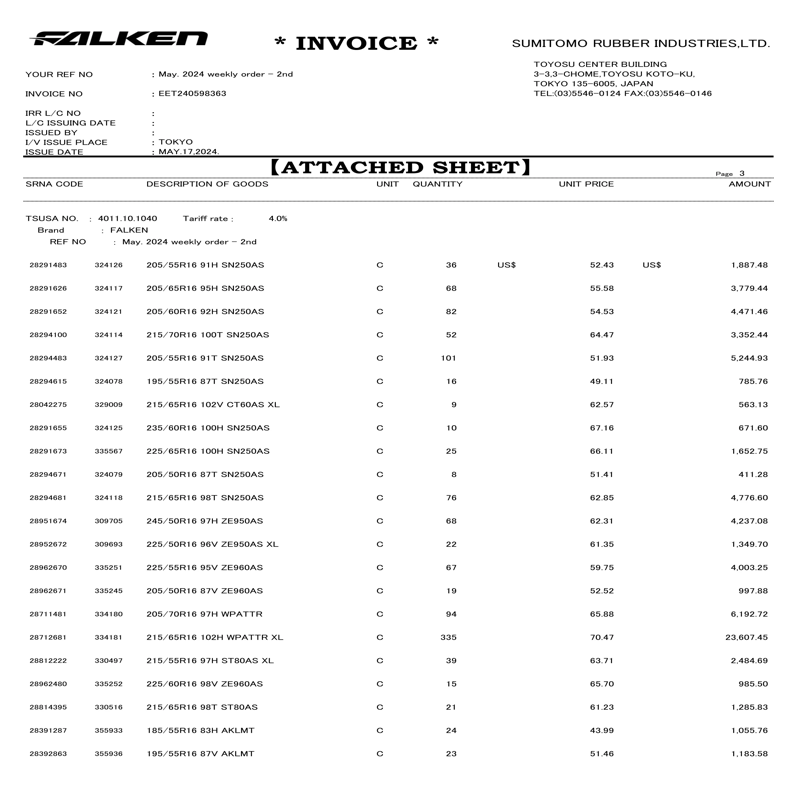

In [17]:
print("This is the example ground truth JSON: ")
print(gt_xml_0)

print("This is the example image: ")
print()
image_0

In [20]:
# Step 2: Load sample[1] (Inference example)
img_path_1, word_boxes_1 = get_image_and_jsongt(sample[12][1])
sorted_ocr_1 = sort_ocr_by_position(word_boxes_1)
gt_xml_1, ocr_text_1 = get_final_xml(sorted_ocr_1)
image_1 = Image.open(img_path_1).convert("RGB").resize((800, 800))

# Step 3: Construct prompt
prompt = [
    {
        "role": "user",
        "content": [
            {"type": "image"},  # Example image (image_0 will be passed to the model separately)
            {
                "type": "text",
                "text": (
                    "This is an example invoice image.\n"
                    "Below is the OCR extracted text from this image:\n\n"
                    f"{ocr_text_0}\n\n"
                    "Based on this invoice and OCR, the correct structured XML is:\n\n"
                    f"{gt_xml_0}\n\n"
                    "Learn from this format, structure, and tagging."
                )
            }
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},  # Inference image (image_1 will be passed to the model separately)
            {
                "type": "text",
                "text": (
                    "Now analyze this new invoice image.\n"
                    "Here is the OCR extracted text for this image:\n\n"
                    f"{ocr_text_1}\n\n"
                    "Based on the invoice and the OCR, generate the structured XML output following the same tags and structure as shown in the example above.\n\n"
                    "You must perform exceptionally well on invoices of varying formats, layouts, and languages.\n\n"
                    "Use the following template to guide your structure:\n"
                    "<s_invoice_date></s_invoice_date>\n"
                    "<s_invoice_number></s_invoice_number>\n"
                    "<s_invoice_total></s_invoice_total>\n"
                    "<s_po_number></s_po_number>\n"
                    "<s_line>\n"
                    "    <s_quantity></s_quantity>\n"
                    "    <s_product_description></s_product_description>\n"
                    "    <s_unit_price></s_unit_price>\n"
                    "    <s_origin_country></s_origin_country>\n"
                    "    <s_line_item_total></s_line_item_total>\n"
                    "</s_line>"
                )
            }
        ]
    }
]

This is the inference image: 


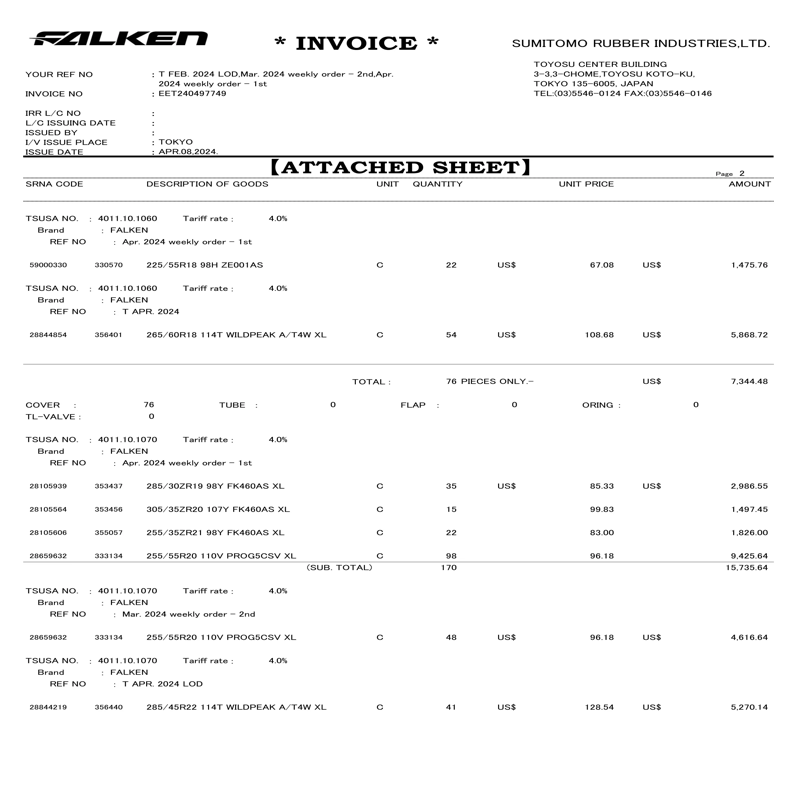

In [21]:
print("This is the inference image: ")
image_1

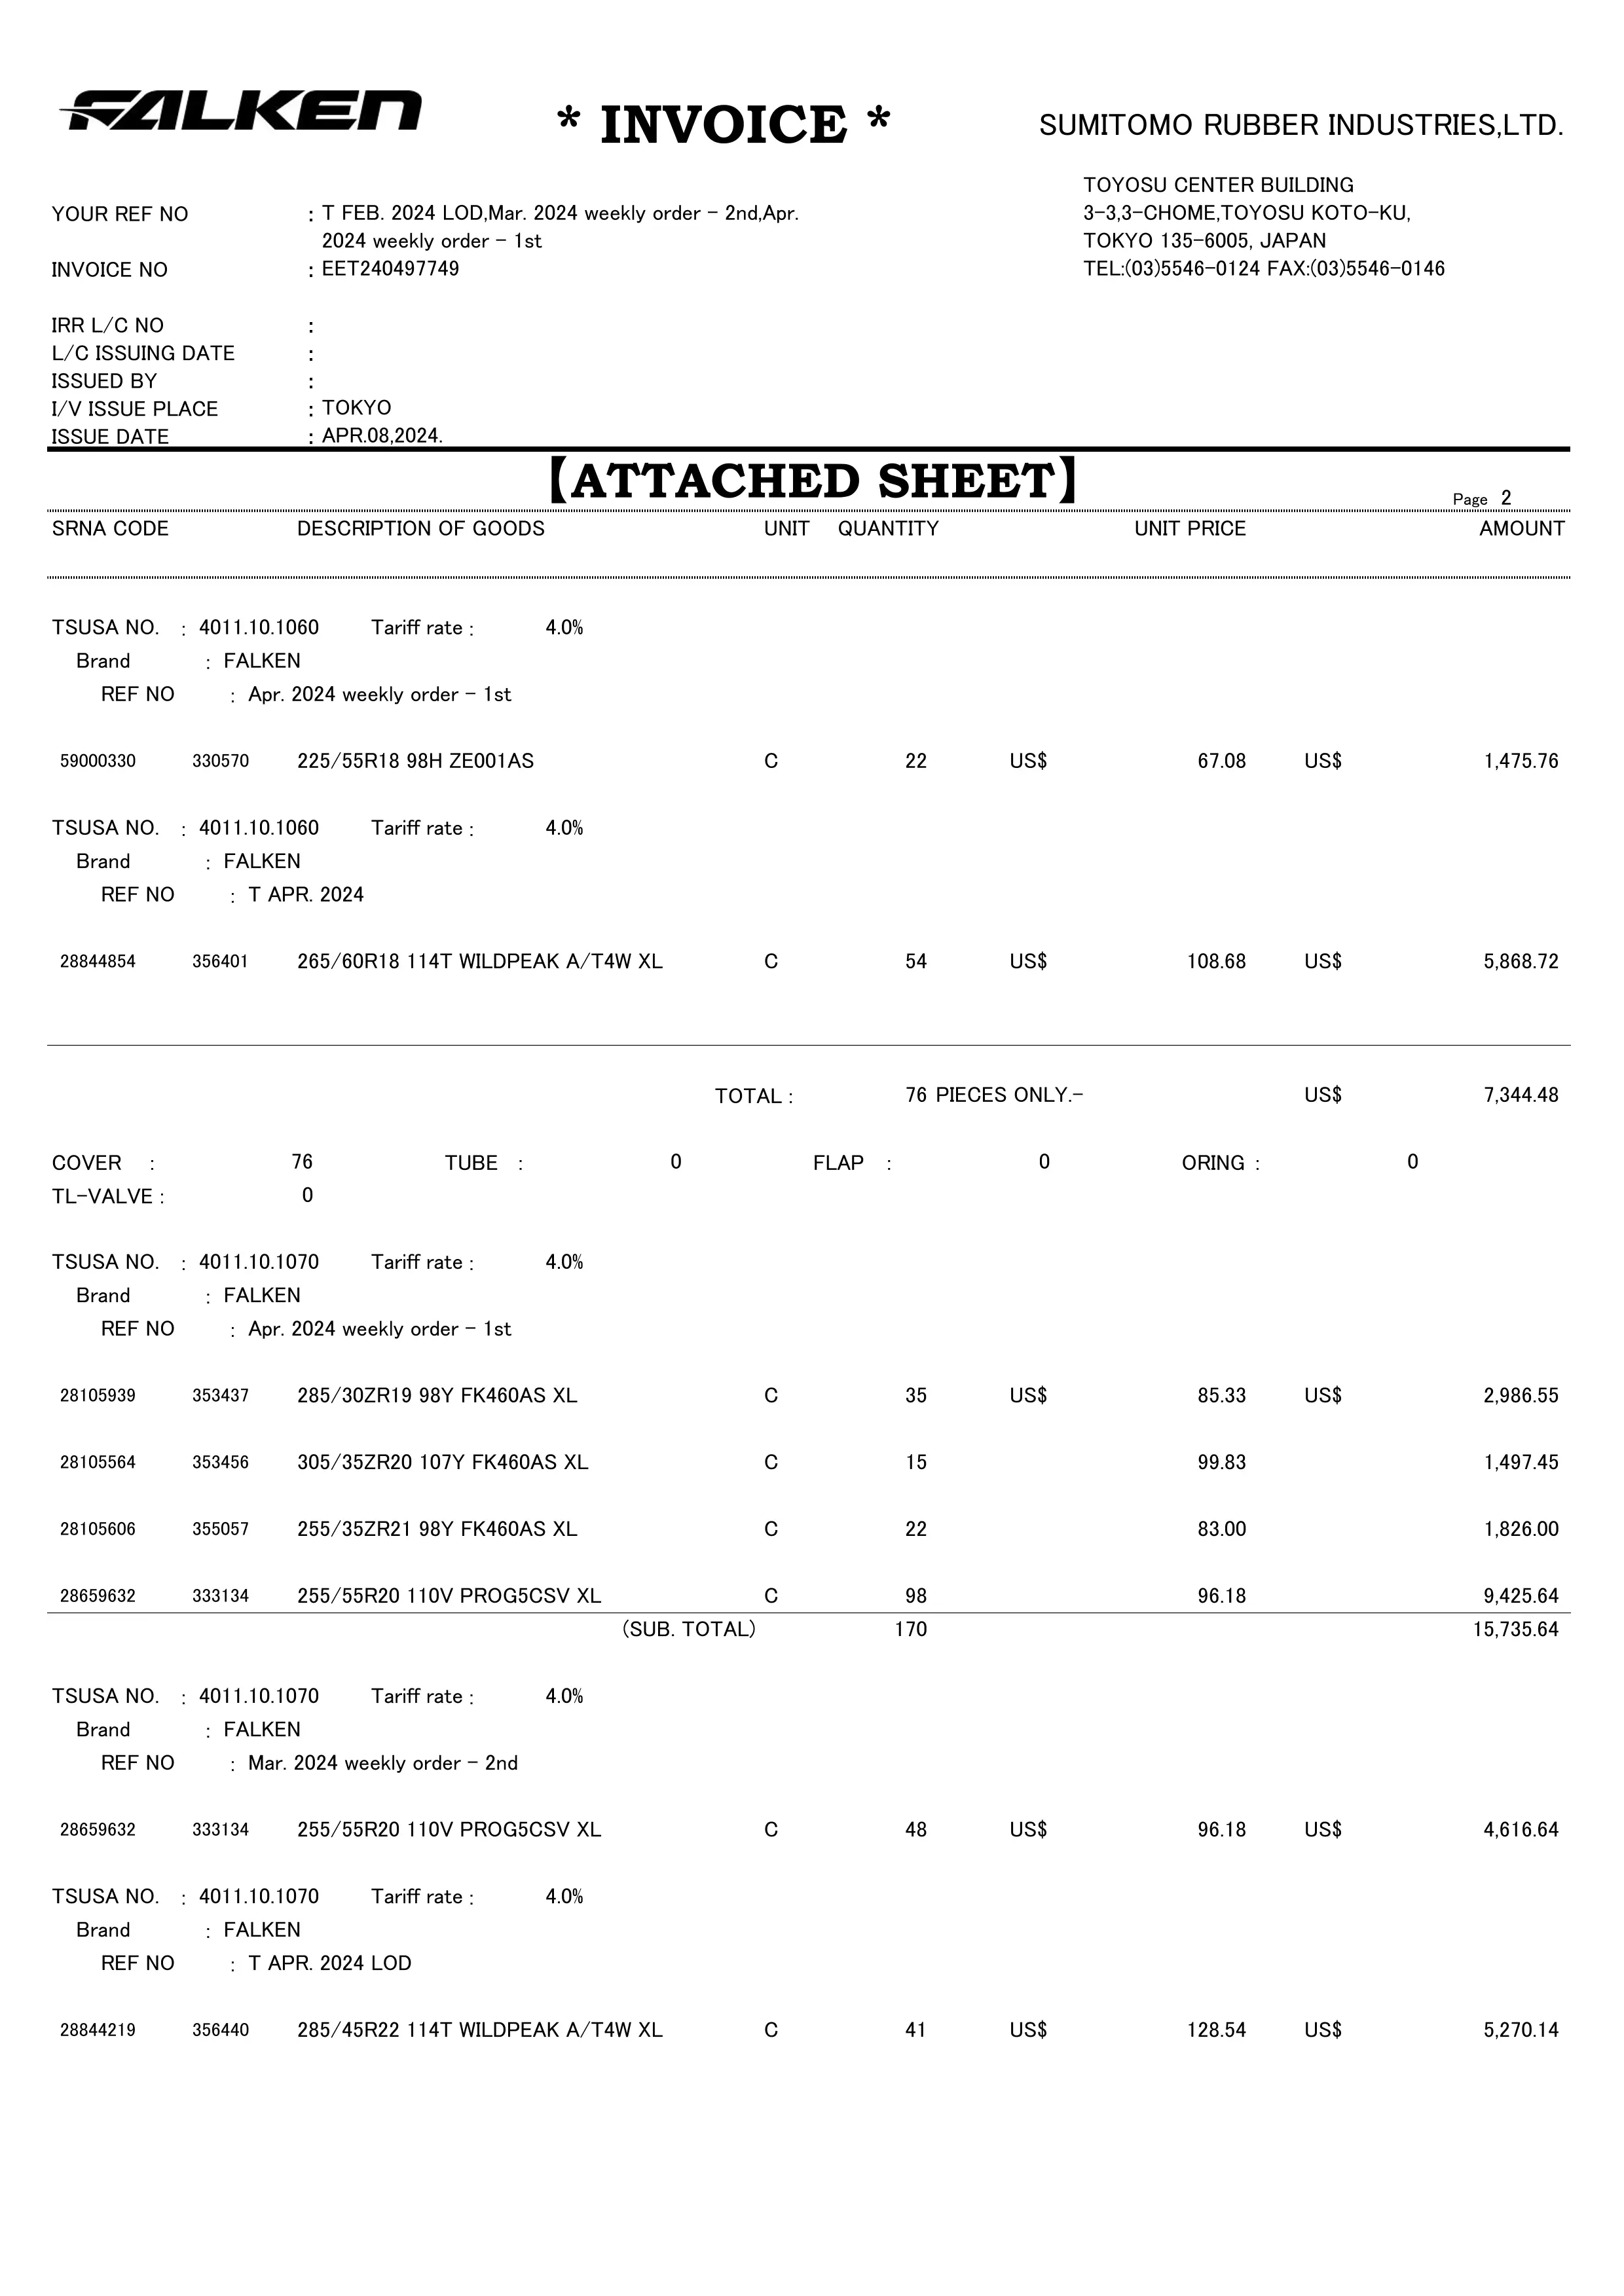

In [22]:
from IPython.display import Image, display
import shutil
# Display
display(Image(filename=img_path_1))

# Copy it to download with a simpler name
# shutil.copy(img_path_1, "oneshot-image-4.jpg")


## Generating Inference output using one shot

In [23]:
# Step 4: Apply prompt template
formatted_prompt = processor.apply_chat_template(prompt, add_generation_prompt=True)

# Step 5: Tokenize and move to device
inputs = processor(text=formatted_prompt, images=[image_0, image_1], return_tensors="pt").to(model.device)

# Step 6: Generate XML output
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=2048,
        temperature=0.1,
        top_p=0.9
    )

# Step 7: Decode model output
response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)[0]
print(response.strip())
print()
print("This should be the output of inference image: ", gt_xml_1)

system
You are a helpful assistant.
user
This is an example invoice image.
Below is the OCR extracted text from this image:

FALKEN * INVOICE * SUMITOMO RUBBER INDUSTRIES.LTD . TOYOSU CENTER BUILDING 2nd weekly order - May . 2024 3-3,3 - CHOME , TOYOSU KOTO - KU , : YOUR REF NO TOKYO 135-6005 , JAPAN TEL : ( 03 ) 5546-0124 FAX : ( 03 ) 5546-0146 EET240598363 : INVOICE NO IRR L / C NO : L / C ISSUING DATE : BY ISSUED TOKYO I / V ISSUE PLACE : MAY.17,2024 . : ISSUE DATE 【 ATTACHED SHEET 】 3 Page AMOUNT DESCRIPTION OF GOODS UNIT UNIT PRICE SRNA CODE QUANTITY Tariff 4011.10.1040 4.0 % TSUSA NO . : rate : Brand FALKEN : order - 2nd 2024 weekly May . REF NO : 0 36 US $ US $ 1,887.48 205 / 55R16 91H SN250AS 52.43 28291483 324126 205 / 65R16 95H SN250AS 55.58 3,779.44 68 324117 28291626 54.53 205 / 60R16 92H SN250AS с 4,471.46 28291652 82 324121 215 / 70R16 100T SN250AS 52 64.47 3,352.44 28294100 324114 101 205 / 55R16 91T SN250AS 51.93 5,244.93 28294483 324127 195 / 55R16 87T SN250AS 324078 1

## Zero shot prompting

In [23]:
# # Load and resize image
# img_path, word_boxes = get_image_and_jsongt(sample[1])
# sorted_ocr = sort_ocr_by_position(word_boxes)
# output_img = get_final_xml(sorted_ocr)
# image = Image.open(img_path).convert("RGB").resize((512, 512))

# # Define the prompt as per your XML requirement
# prompt = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"},
#             {
#                 "type": "text",
#                 "text": """Extract the following invoice details from the image and return only in this XML format:
# <s_invoice_date></s_invoice_date>
# <s_invoice_number></s_invoice_number>
# <s_line>
#     <s_sku></s_sku>
#     <s_product_description></s_product_description>
#     <s_hts_number></s_hts_number>
#     <s_origin_country></s_origin_country>
#     <s_quantity></s_quantity>
#     <s_unit_price></s_unit_price>
#     <s_line_item_total></s_line_item_total>
# </s_line>"""
#             }
#         ]
#     }
# ]

## Improved version of the zero shot

In [24]:
# # Load and resize image
# img_path, word_boxes = get_image_and_jsongt(sample[18])
# sorted_ocr = sort_ocr_by_position(word_boxes)
# gt_xml_1, ocr_text_1 = get_final_xml(sorted_ocr)
# image = Image.open(img_path).convert("RGB").resize((1024, 1024))

# prompt = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"},
#             {
#                 "type": "text",
#                 "text": """You are a highly capable document understanding assistant specialized in parsing complex invoice formats, including multilingual invoices.

# Your task is to extract invoice details from the image above and return the information strictly using the XML structure shown below.

# Respond with **only the XML output**, and ensure the tag structure and hierarchy remain intact, even if some fields are missing (leave such tags empty).

# If the image does not exactly match the expected structure, use your best understanding to fill in the XML fields as accurately as possible based on the image content.

# You must perform exceptionally well on invoices of varying formats, layouts, and languages.

# Return your response strictly in this format:

# <s_invoice_date></s_invoice_date>
# <s_invoice_number></s_invoice_number>
# <s_line>
#     <s_sku></s_sku>
#     <s_product_description></s_product_description>
#     <s_hts_number></s_hts_number>
#     <s_origin_country></s_origin_country>
#     <s_quantity></s_quantity>
#     <s_unit_price></s_unit_price>
#     <s_line_item_total></s_line_item_total>
# </s_line>

# Do NOT add any explanation, preamble, or postamble — only return the pure XML content."""
#             }
#         ]
#     }
# ]


In [ ]:
from PIL import Image

img_path, word_boxes = get_image_and_jsongt(sample[123])
sorted_ocr = sort_ocr_by_position(word_boxes)
gt_xml_1, ocr_text_1 = get_final_xml(sorted_ocr)
image = Image.open(img_path).convert("RGB").resize((1024, 1024))


prompt = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {
                "type": "text",
                "text": f"""You are a highly capable document understanding assistant specialized in parsing complex invoice formats, including multilingual invoices.

Your task is to extract invoice details from the image above and return the information strictly using the XML structure shown below.

Here is the OCR output of the image (sorted visually in reading order):
{ocr_text_1}

If the image does not exactly match the expected structure, use your best understanding to fill in the XML fields as accurately as possible based on the image content.

You must perform exceptionally well on invoices of varying formats, layouts, and languages.

Return your response strictly in this format:

<s_invoice_date></s_invoice_date>
<s_invoice_number></s_invoice_number>
<s_line>
    <s_sku></s_sku>
    <s_product_description></s_product_description>
    <s_hts_number></s_hts_number>
    <s_origin_country></s_origin_country>
    <s_quantity></s_quantity>
    <s_unit_price></s_unit_price>
    <s_line_item_total></s_line_item_total>
</s_line>

Do NOT add any explanation, preamble, or postamble — only return the pure XML content."""
            }
        ]
    }
]


In [ ]:
image

In [ ]:
print(f"This is the extracted ocr text of inference image: \n\n{ocr_text_1}\n\n")
print(f"This is the ground truth JSON of the inference image: \n\n{gt_xml_1}")

In [ ]:
from IPython.display import Image, display
import shutil
# Display
display(Image(filename=img_path))

# Copy it to download with a simpler name
shutil.copy(img_path, "zeroshot-image-123.jpg")


## Generating answer from the model

In [ ]:
# Format the prompt into a model-readable string
formatted_prompt = processor.apply_chat_template(prompt, add_generation_prompt=True)


# Tokenize and preprocess
inputs = processor(text=formatted_prompt, images=[image], return_tensors="pt").to(model.device)

# Generate output
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=6144,
        temperature=0.1,
        top_p=0.9
    )

# Decode the response
response = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
print(response.strip())

## Trying to generate with First Five images of dataset 

In [ ]:
# Directory setup
image_paths = [
    sample[0][0],
    sample[1][0],
    sample[2][0],
    sample[3][0],
    sample[4][0],
]

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Define prompt once
prompt = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {
                "type": "text",
                "text": """Extract the following invoice details from the image and return only in this XML format:
<s_invoice_date></s_invoice_date>
<s_invoice_number></s_invoice_number>
<s_po_number></s_po_number>
<s_invoice_total></s_invoice_total>
<s_line>
    <s_sku></s_sku>
    <s_product_description></s_product_description>
    <s_hts_number></s_hts_number>
    <s_origin_country></s_origin_country>
    <s_quantity></s_quantity>
    <s_unit_price></s_unit_price>
    <s_line_item_total></s_line_item_total>
</s_line>"""
            }
        ]
    }
]

# Generate formatted prompt once
formatted_prompt = processor.apply_chat_template(prompt, add_generation_prompt=True)

## Generating output

In [ ]:
# Process images
for image_path in image_paths:
    try:
        # Load and resize image
        image = Image.open(image_path).convert("RGB").resize((512, 512))
        
        # Tokenize and preprocess
        inputs = processor(text=formatted_prompt, images=[image], return_tensors="pt").to(model.device)

        # Generate output
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=1024,
                temperature=0.1,
                top_p=0.9
            )

        # Decode the response
        response = tokenizer.batch_decode(output, skip_special_tokens=True)[0]

        # Clean the output: only keep the XML block
        start_tag = "<s_invoice_date>"
        if start_tag in response:
            xml_start = response.find(start_tag)
            xml_output = response[xml_start:].strip()
        else:
            xml_output = response.strip()

        # Save to output file
        filename = os.path.basename(image_path).replace(".png", ".xml").replace("/", "_")
        with open(os.path.join(output_dir, filename), "w") as f:
            f.write(xml_output)

        print(f"[✓] Processed: {image_path} → {filename}")

    except Exception as e:
        print(f"[!] Error processing {image_path}: {e}")